## Imports

In [1]:
import os
import jax
import jax.numpy as jnp
import numpy as np
import optax
import flax.linen as nn
import matplotlib.pyplot as plt

from flax.training import train_state
from tensorflow.keras.datasets import mnist

NUM_CLASSES = 10

## Model

In [2]:
class CNN(nn.Module):
  kernel_size: int
  stride: int
  conv_size: int
  ff_hidden_dim: int
  out_dim: int

  @nn.compact
  def __call__(self, x):
    x = nn.Conv(features = self.conv_size, kernel_size = (self.kernel_size, self.kernel_size))(x)
    x = nn.relu(x)
    x = nn.avg_pool(x, window_shape = (self.stride, self.stride), strides = (self.stride, self.stride))

    x = nn.Conv(features = 2 * self.conv_size, kernel_size = (self.kernel_size, self.kernel_size))(x)
    x = nn.relu(x)
    x = nn.avg_pool(x, window_shape = (self.stride, self.stride), strides = (self.stride, self.stride))

    x = x.reshape((x.shape[0], -1))
    x = nn.Dense(self.ff_hidden_dim)(x)
    x = nn.relu(x)
    x = nn.Dense(self.out_dim)(x)
    return x

## Initialize Train State

In [3]:
def create_train_state(rng, input_shape, learning_rate, model):

  @jax.jit
  def initialize_model(rng):
    return model.init(rng, jnp.ones(input_shape, dtype = jnp.float32))["params"]

  params = initialize_model(rng)
  tx = optax.adam(learning_rate = learning_rate)
  return train_state.TrainState.create(
      apply_fn = model.apply,
      params = params,
      tx = tx
  )

## Loss Function

In [4]:
@jax.jit
def update_step(state, batch):
  def loss_fn(params, batch):
    logits = state.apply_fn({"params": params}, batch["image"])
    labels = jax.nn.one_hot(batch["label"], NUM_CLASSES)
    loss = jnp.mean(optax.softmax_cross_entropy(logits = logits, labels = labels))
    return loss

  grad_fn = jax.value_and_grad(loss_fn)
  loss, grads = grad_fn(state.params, batch)
  return state.apply_gradients(grads = grads), loss

## Prepare Data

In [5]:
def prepare_data(data_fraction, batch_size):
  (x_train, y_train), (x_test, y_test) = mnist.load_data()
  x_train = x_train[:, :, :, jnp.newaxis].astype("float32") / 255
  x_test = x_test[:, :, :, jnp.newaxis].astype("float32") / 255
  dataset_size = len(x_train)
  x_train = x_train[:int(data_fraction * dataset_size)]

  def create_sharded_batch(x, y, batch_size):
    num_samples = x.shape[0]
    indices = np.arange(num_samples)
    np.random.shuffle(indices)

    for i in range(0, num_samples, batch_size):
      batch_indices = indices[i: i + batch_size]
      yield {
        "image": x[batch_indices],
        "label": y[batch_indices]
      }

  return create_sharded_batch(x_train, y_train, batch_size)


## Train Model

Data fraction 0.2 | Loss 0.07939261198043823
Data fraction 0.4 | Loss 0.039565689861774445
Data fraction 0.6 | Loss 0.03260890021920204
Data fraction 0.8 | Loss 0.027971740812063217
Data fraction 1.0 | Loss 0.02270924672484398
Conv size 4, FF Hidden dim 64 | Loss 0.08045504242181778
Conv size 8, FF Hidden dim 128 | Loss 0.0430968813598156
Conv size 16, FF Hidden dim 256 | Loss 0.02423190511763096
Conv size 32, FF Hidden dim 512 | Loss 0.00843917764723301


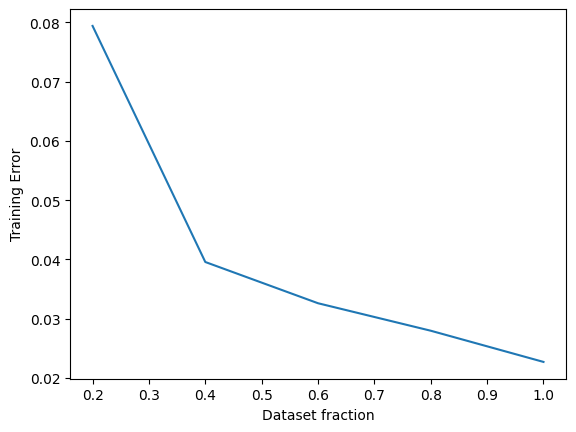

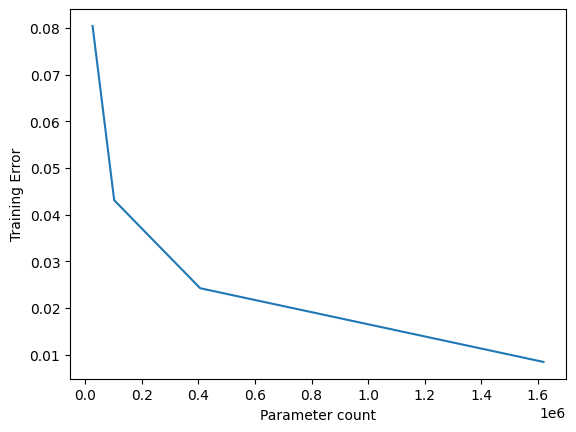

In [6]:
def main():
  BATCH_SIZE = 1024
  LEARNING_RATE = 1e-3
  NUM_EPOCHS = 20
  CONV_SIZE = 16
  KERNEL_SIZE = 2
  STRIDE = 2
  FF_HIDDEN_DIM = 256
  DATA_FRACTION = 1.0

  store = {
      "data_fraction": [0.2, 0.4, 0.6, 0.8, 1.0],
      "conv_size": [4, 8, 16, 32],
      "ff_hidden_dim": [64, 128, 256, 512],
      "parameter_count": []
  }
  data_variation = []
  model_variation = []

  for fraction in store["data_fraction"]:
    rng = jax.random.PRNGKey(42)
    model = CNN(kernel_size = KERNEL_SIZE, stride = STRIDE, conv_size = CONV_SIZE, ff_hidden_dim = FF_HIDDEN_DIM, out_dim = NUM_CLASSES)
    state = create_train_state(rng, (1, 28, 28, 1), LEARNING_RATE, model)
    for i in range(NUM_EPOCHS):
      data_iterator = prepare_data(fraction, BATCH_SIZE)
      epoch_loss = 0.0
      num_batches = 0

      for batch in data_iterator:
        state, loss = update_step(state, batch)
        epoch_loss += loss
        num_batches += 1

      avg_loss = epoch_loss / num_batches
    print(f"Data fraction {fraction} | Loss {avg_loss}")
    data_variation.append(avg_loss)


  for conv_size, ff_hidden_dim in zip(store["conv_size"], store["ff_hidden_dim"]):
    rng = jax.random.PRNGKey(42)
    model = CNN(kernel_size = KERNEL_SIZE, stride = STRIDE, conv_size = conv_size, ff_hidden_dim = ff_hidden_dim, out_dim = NUM_CLASSES)
    state = create_train_state(rng, (1, 28, 28, 1), LEARNING_RATE, model)
    store["parameter_count"].append(sum(x.size for x in jax.tree_util.tree_leaves(state.params)))
    for i in range(NUM_EPOCHS):
      data_iterator = prepare_data(DATA_FRACTION, BATCH_SIZE)
      epoch_loss = 0.0
      num_batches = 0

      for batch in data_iterator:
        state, loss = update_step(state, batch)
        epoch_loss += loss
        num_batches += 1

      avg_loss = epoch_loss / num_batches
    print(f"Conv size {conv_size}, FF Hidden dim {ff_hidden_dim} | Loss {avg_loss}")
    model_variation.append(avg_loss)

  plt.figure()
  plt.plot(store["data_fraction"], data_variation)
  plt.xlabel("Dataset fraction")
  plt.ylabel("Training Error")

  plt.figure()
  plt.plot(store["parameter_count"], model_variation)
  plt.xlabel("Parameter count")
  plt.ylabel("Training Error")

if __name__ == "__main__":
  main()
